## Compare all tflite 

All tflite models are compared against each other.

As can be seen, the quantized model often loses accuracy.

ana0910s1 - models are not trained on the relabeled data. So the accuracy is much less against the other models.


In [21]:
########### Basic Parameters for Running: ################################
    
input_shape = (32,20,3)

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow import keras
from sklearn.model_selection import train_test_split
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [22]:
Input_dir='images'

files = glob.glob(Input_dir + '/*.jpg')
y_data = np.empty((len(files)))
f_data = np.empty((len(files)), dtype="<U250")
x_data = np.empty((len(files),input_shape[0],input_shape[1],input_shape[2]))

for i, aktfile in enumerate(files):
    base = os.path.basename(aktfile)

    # get label from filename (1.2_ new or 1_ old),
    if (base[1]=="."):
        target = base[0:3]
    else:
        target = base[0:1]
    category = float(target)
    
    test_image = Image.open(aktfile).resize((input_shape[1],input_shape[0]), Image.Resampling.NEAREST)
    test_image = np.array(test_image, dtype="float32")
    f_data[i] =  aktfile
    x_data[i] = test_image
    y_data[i] =  category
print("Analog data count: ", len(y_data))  

Analog data count:  2826


## functions for evaluation

The functions to evaluate the models.

In [23]:
import numpy as np
from tensorflow import keras
import pandas as pd

def plot_dataset(images, labels, columns=10, rows=5, figsize=(18, 10)):

    fig = plt.figure(figsize=figsize)
    
    for i in range(1, columns*rows +1):
        if (i>len(labels)):
            break
        fig.add_subplot(rows, columns, i)
        plt.title(labels[i-1])  # set title
        plt.imshow((images[i-1]).astype(np.uint8), aspect='1', extent=[0, 1, 0, 1])
        # yellow lines
        ax=plt.gca()
        ax.get_yaxis().set_visible(False) 
        ax.get_xaxis().set_visible(False) 
        
        plt.tight_layout()
    plt.show()

def plot_divergence(divergationset, title1, nb_classes):
    fig = plt.figure(figsize=(40, 10))
    fig.suptitle(title1, fontsize=32)
    plt.bar(np.arange (0, nb_classes/10, 0.1), divergationset, width=0.09, align='center')
    plt.ylabel('count')
    plt.xlabel('digit class')
    plt.xticks(np.arange(0, nb_classes/10, 0.1))
    plt.show()
    return fig

def evaluate_ziffer_tflite(model_path, x_data, y_data, f_data, title, max_delta = 0.11):
    false_images = []
    false_labels = []
    false_predicted = []

    # we use the tflite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    # ignore models with other shape than 32,32,3
    if ((interpreter.get_input_details()[0]["shape"] != (1, 32, 20, 3)).any()):
        return


    for x, y, f in zip(x_data, y_data, f_data):
        
        interpreter.set_tensor(input_index, np.expand_dims(x.astype(np.float32), axis=0))
        # Run inference.
        interpreter.invoke()
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.get_tensor(output_index)
        if (len(output[0])==2):
            out_sin = output[0][0]  
            out_cos = output[0][1]
            prediction = ((np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1)*10
        else:
            prediction = (np.argmax(output, axis=1).reshape(-1)/10)[0]

        difference = min(abs(prediction-y), abs(prediction-(10-y)))
        #print(prediction, y, difference)
        if difference>max_delta:
            false_images.append(x)
            false_labels.append( "Expected: " + str(y) + "\n Predicted: " + str(prediction) + "\n" + str(f)[-28:-5])
            false_predicted.append(difference)
               
    
    title = f"Model: {os.path.basename(model_path)}, Tested images: {len(y_data)}. {len(false_labels)} false predicted. Accuracy is: {1-len(false_labels)/len(y_data)}\nDeviation of false predicted"
    # plot the differences (max difference can only be 5.0)
    plot_divergence(np.bincount(np.array(np.array(false_predicted)*10).astype(int), minlength=51), title, 51)

    # plot the false predicted images
    #plot_dataset(np.array(false_images), false_labels, columns=7, rows=7, figsize=(18,18))


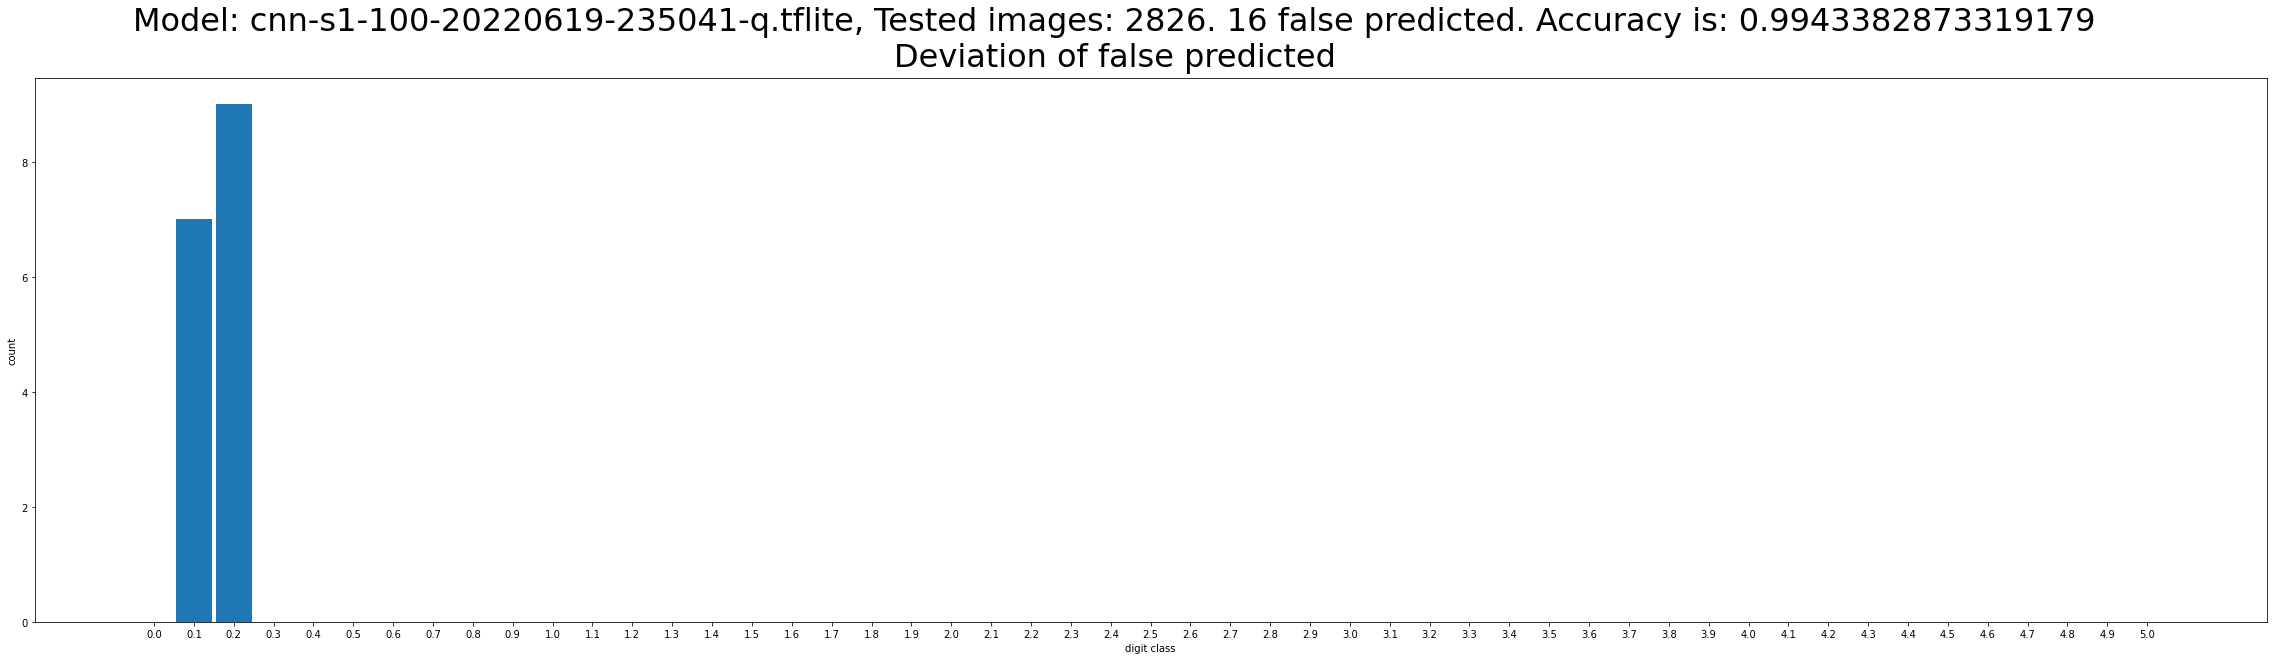

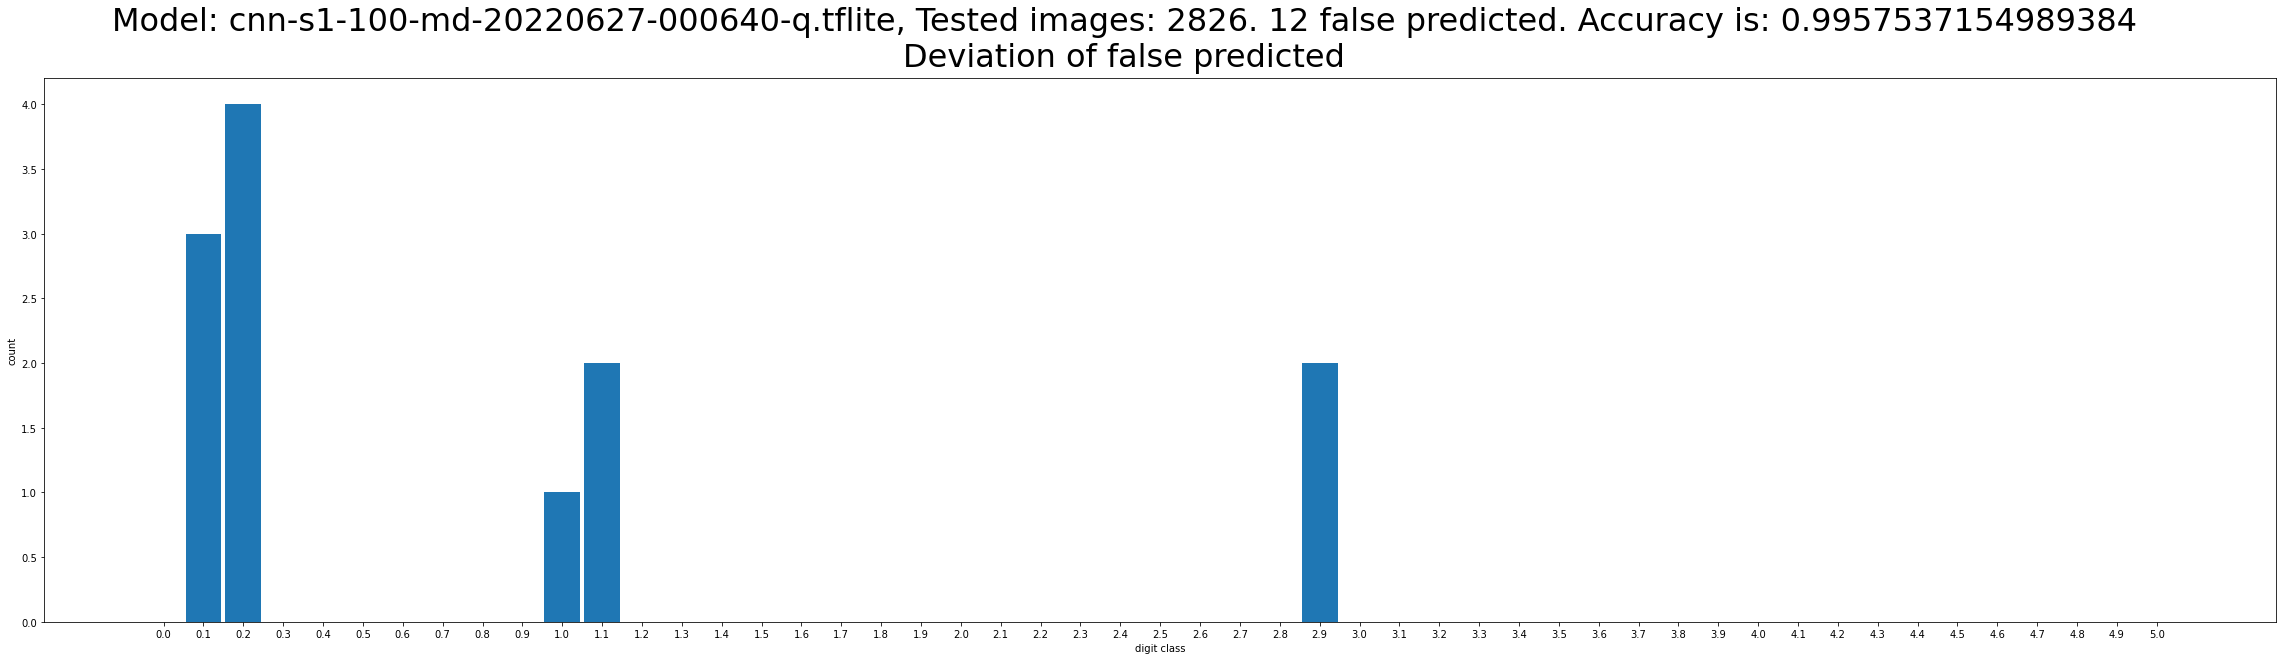

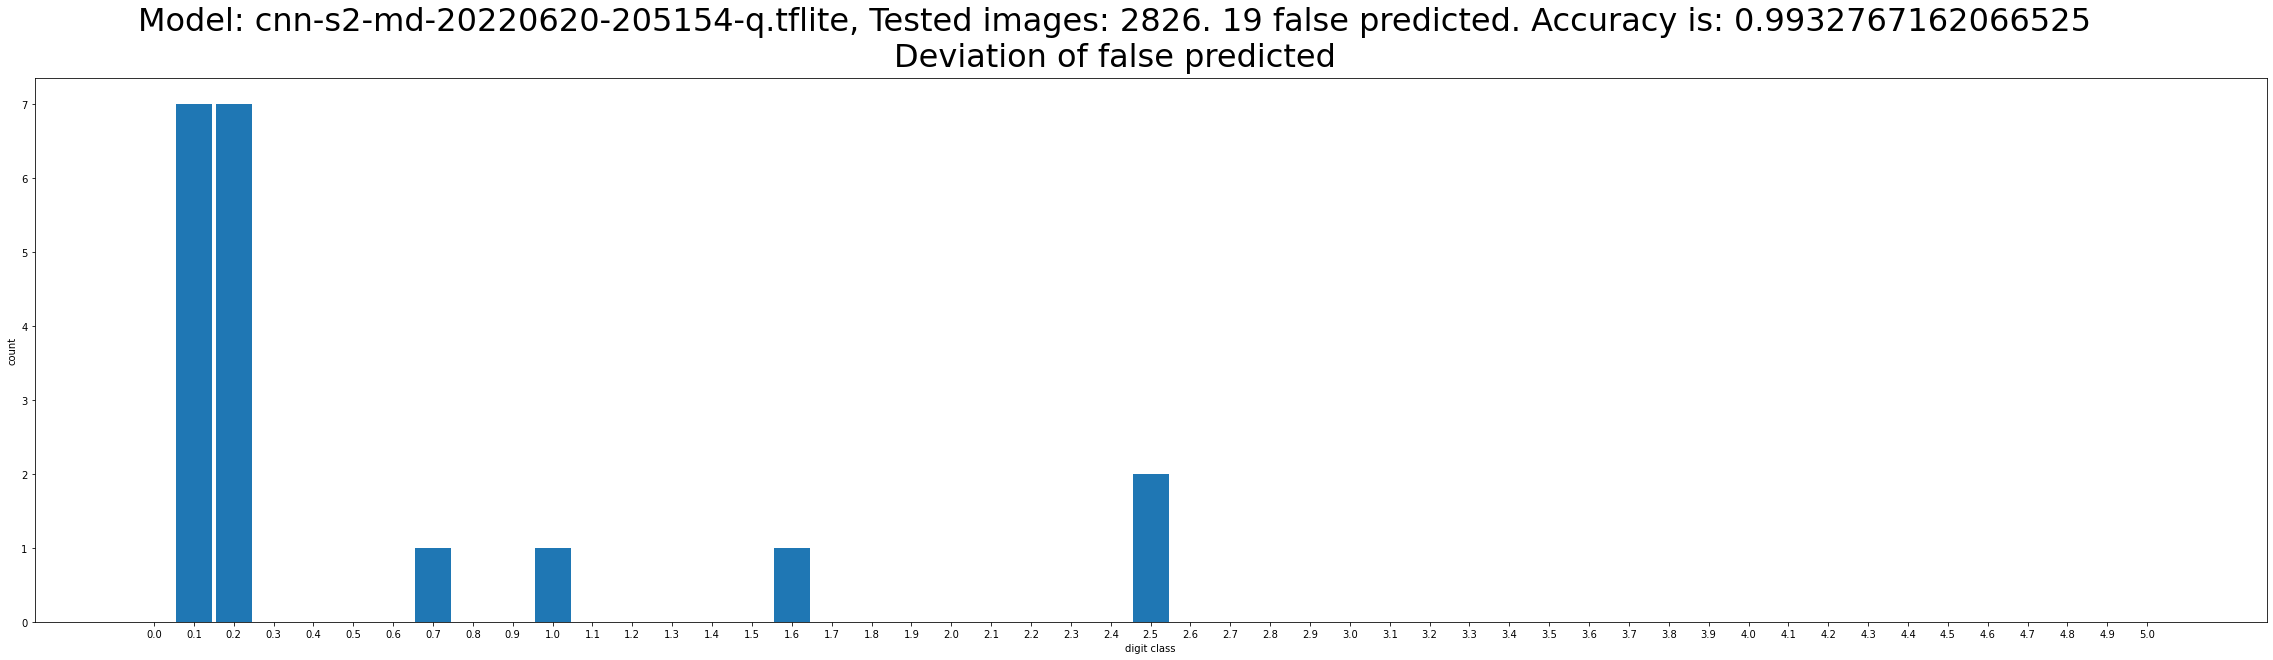

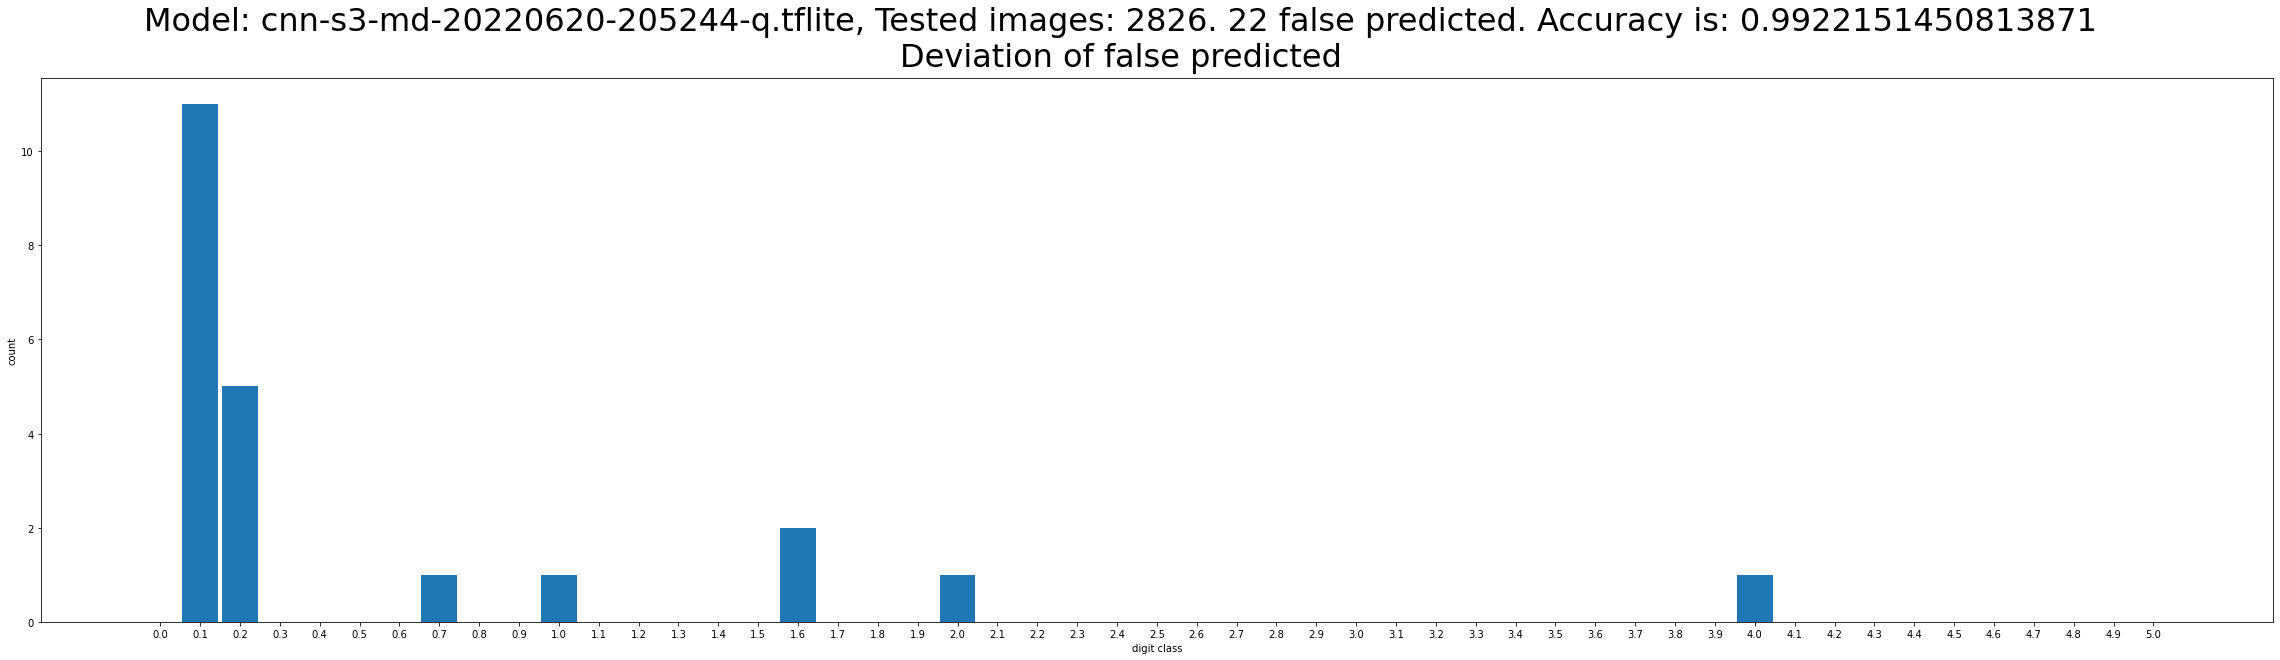

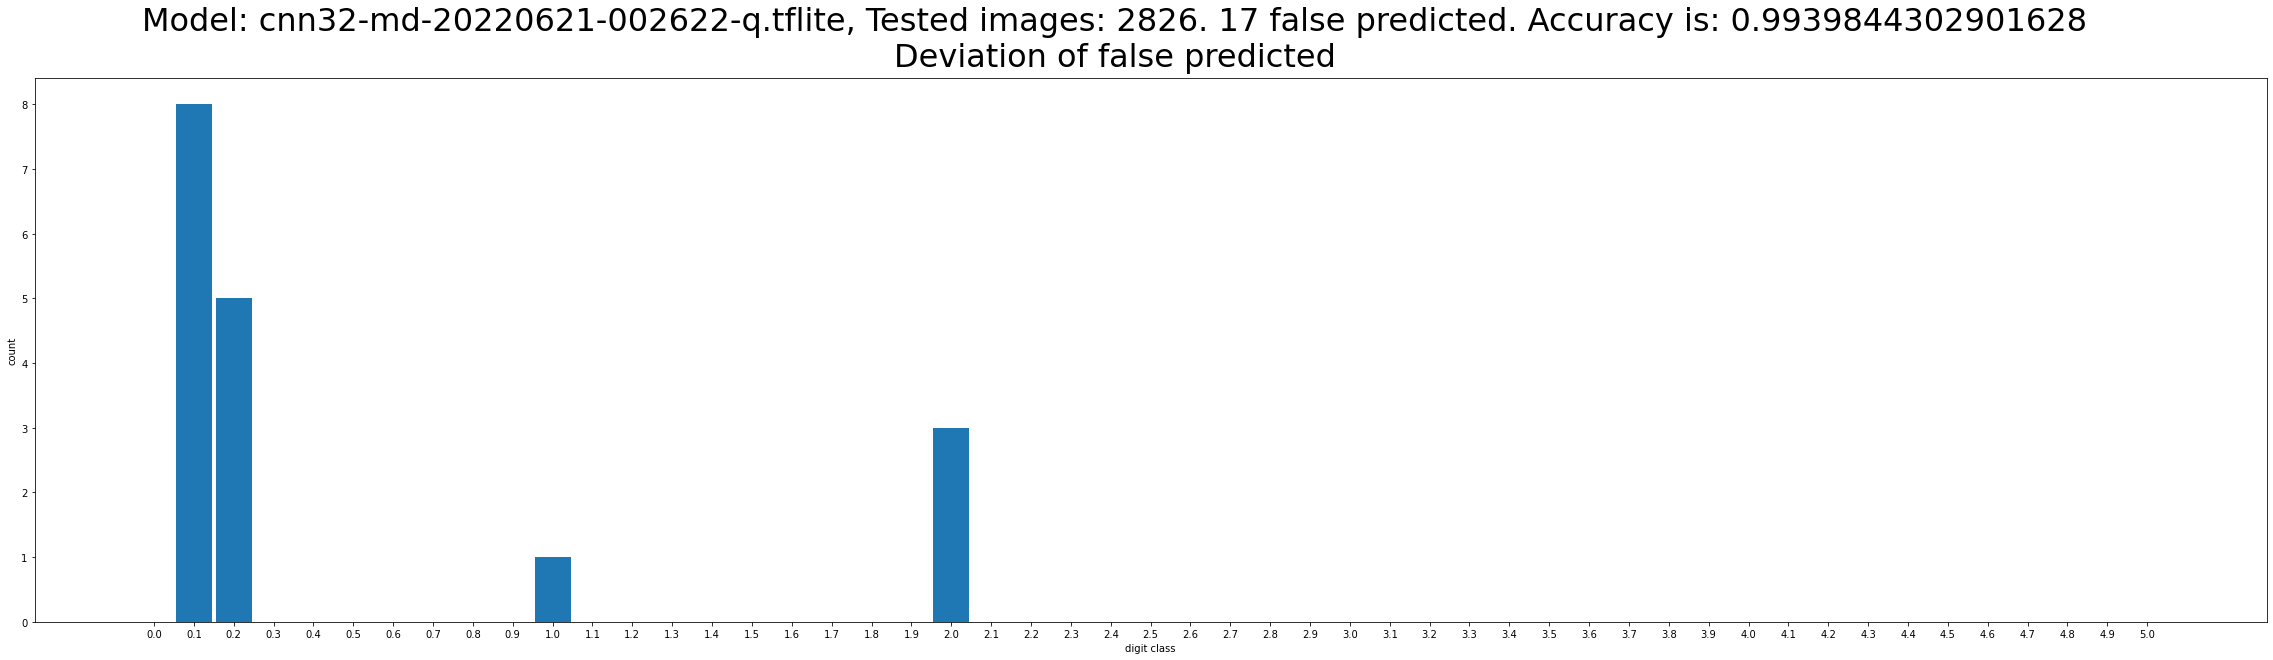

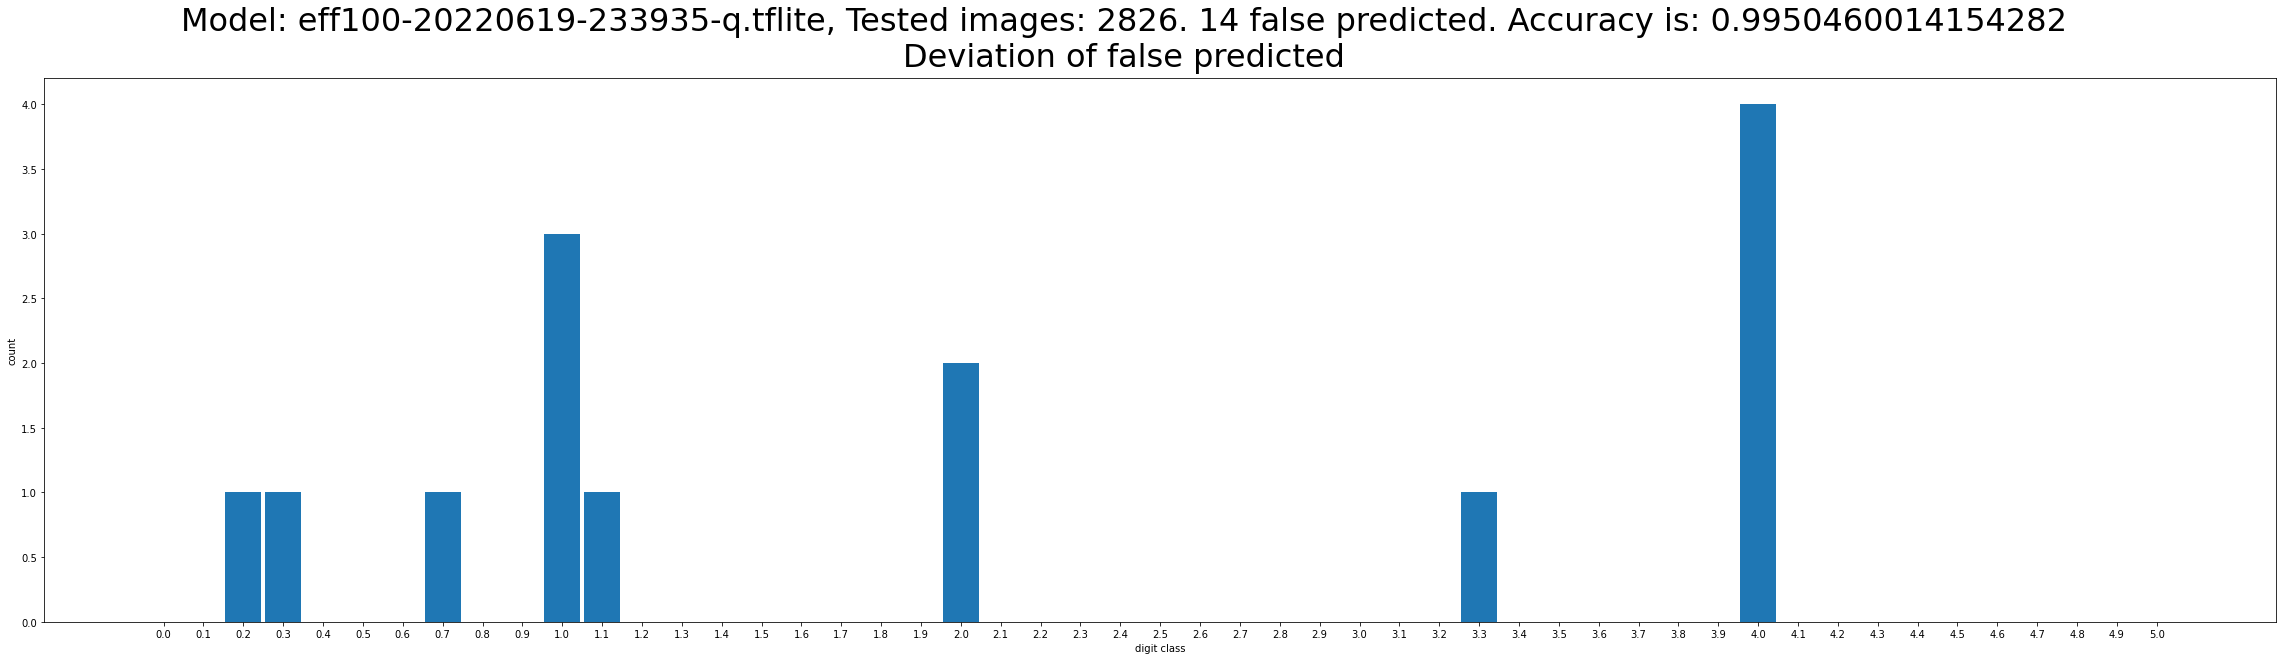

In [24]:
modelfiles = sorted(glob.glob('output/*.tflite'))
for modelfile in modelfiles:
    evaluate_ziffer_tflite(modelfile, x_data, y_data, f_data, title=modelfile, max_delta=0.11)